### Optimal control of the Hopf model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.hopf import HopfModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_hopf

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 3

# We define colors for later convenience
color_x = 'red'
color_y = 'blue'

In [2]:
# We import the model
hopf = HopfModel()

# Some parameters to define stimulation signals
dt = hopf.params["dt"]
duration = 10.
amplitude = 1.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-2] = np.sin(np.arange(0,duration-0.2, dt)) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
hopf.params["duration"] = duration
x_init = 0.
y_init = 0.
hopf.params["xs_init"] = np.array([[x_init]])
hopf.params["ys_init"] = np.array([[y_init]])

In [3]:
# define plot function for later convenience
def plot_singlenode(state, target, control, input, weight_array=[]):
    fig, ax = plt.subplots( 3,1, figsize=(8,6), constrained_layout=True)

    # Plot the target (dashed line) and unperturbed activity
    t_array = np.arange(0, duration+dt, dt)

    ax[0].plot(t_array, state[0,0,:], label="x", color=color_x)
    ax[0].plot(t_array, state[0,1,:], label="y", color=color_y)
    ax[0].plot(t_array, target[0,0,:], linestyle='dashed', label="Target x", color=color_x)
    ax[0].plot(t_array, target[0,1,:], linestyle='dashed', label="Target y", color=color_y)
    ax[0].legend()
    ax[0].set_title("Activity without stimulation and target activity")

    # Plot the target control signal (dashed line) and "initial" zero control signal
    ax[1].plot(t_array, control[0,0,:], label="stimulation x", color=color_x)
    ax[1].plot(t_array, control[0,1,:], label="stimulation y", color=color_y)
    ax[1].plot(t_array, input[0,0,:], linestyle='dashed', label="input x", color=color_x)
    ax[1].plot(t_array, input[0,1,:], linestyle='dashed', label="input y", color=color_y)
    ax[1].legend()
    ax[1].set_title("Active stimulation and input stimulation")

    ax[2].plot(weight_array)
    ax[2].set_title("Cost throughout optimization.")

    plt.show()

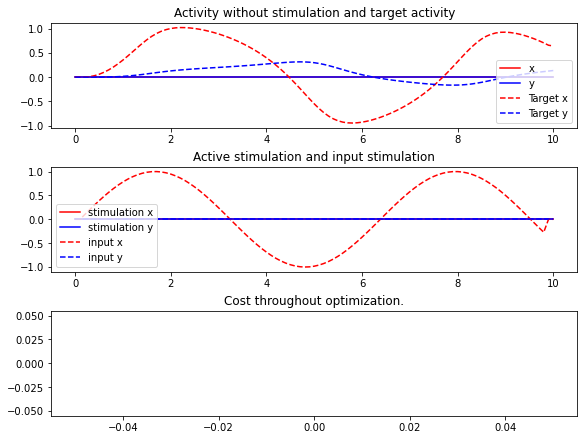

In [4]:
# We set the stimulus in x and y variables, and run the simulation
hopf.params["x_ext"] = input
hopf.params["y_ext"] = zero_input
hopf.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (hopf.params["xs_init"], hopf.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (hopf.x, hopf.y), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
hopf.params["x_ext"] = zero_input
hopf.params["y_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
hopf.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (hopf.params["xs_init"], hopf.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (hopf.x, hopf.y), axis=1)), axis=2)

plot_singlenode(state, target, control, target_input)

Compute control for a deterministic system
Cost in iteration 1: 25.473619566236398


ERROR:root:nan in model output!


diverging model output, decrease step size to  5.0
Cost in iteration 2: 24.51653647628062
Cost in iteration 100: 0.00413925800380901
Cost in iteration 200: 9.880484323919445e-05
Cost in iteration 300: 3.4826363357587354e-05
Cost in iteration 400: 2.057051947386012e-05
Cost in iteration 500: 1.4209798510162877e-05


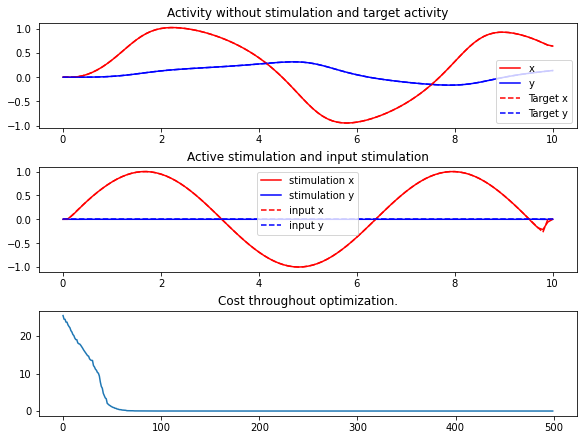

In [5]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
hopf.params["x_ext"] = zero_input
hopf.params["y_ext"] = zero_input
hopf_controlled = oc_hopf.OcHopf(hopf, target, w_p=1, w_2=0, print_array=[1,2,100,200,300,400,500])

# We run 500 iterations of the optimal control gradient descent algorithm
hopf_controlled.optimize(500)

state = hopf_controlled.get_xs()
control = hopf_controlled.control

plot_singlenode(state, target, control, target_input, hopf_controlled.cost_history)

### Network case

In [9]:
# define plot function for later convenience
def plot_nw(state, target, control, input, weight_array=[], step_array=[]):

    t_array = np.arange(0, duration+dt, dt)
    fig, ax = plt.subplots( 3,2, figsize=(12,8), constrained_layout=True)

    for n in range(hopf.params.N):
        ax[0,n].plot(t_array, state[n,0,:], label="x", color=color_x)
        ax[0,n].plot(t_array, state[n,1,:], label="y", color=color_y)
        ax[0,n].plot(t_array, target[n,0,:], linestyle='dashed', label="Target x", color=color_x)
        ax[0,n].plot(t_array, target[n,1,:], linestyle='dashed', label="Target y", color=color_y)
        ax[0,n].legend()
        ax[0,n].set_title(f"Activity and target, node %s" % (n))

        # Plot the target control signal (dashed line) and "initial" zero control signal
        ax[1,n].plot(t_array, control[n,0,:], label="stimulation x", color=color_x)
        ax[1,n].plot(t_array, control[n,1,:], label="stimulation y", color=color_y)
        ax[1,n].plot(t_array, input[n,0,:], linestyle='dashed', label="input x", color=color_x)
        ax[1,n].plot(t_array, input[n,1,:], linestyle='dashed', label="input y", color=color_y)
        ax[1,n].legend()
        ax[1,n].set_title(f"Stimulation and input, node %s" % (n))

    ax[2,0].plot(weight_array)
    ax[2,0].set_title("Cost throughout optimization.")

    ax[2,1].plot(step_array)
    ax[2,1].set_title("Step size throughout optimization.")

    ax[2,1].set_ylim(bottom=0,top=None)

    plt.show()

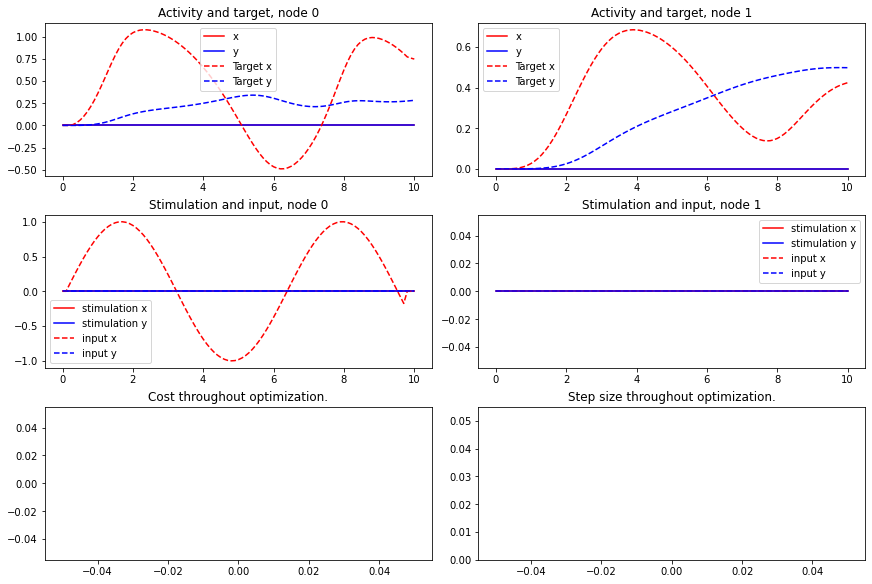

In [10]:
cmat = np.array( [[0., 1.], [0.5, 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

hopf = HopfModel(Cmat=cmat, Dmat=dmat)
hopf.params.coupling = "additive" # use additive coupling

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (hopf.params.N, len(hopf.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in y-channel in node 0

if control_mat[0,0] == 0. and control_mat[1,0] == 0:
    # if x is input channel, high connection strength can lead to numerical issues
    hopf.params.K_gl = 5. # increase for stronger connectivity, WARNING: too high value will cause numerical problems

hopf.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = np.sin(np.arange(0,duration-0.3, dt)) # other functions or random values can be used as well
hopf.params["xs_init"] = np.vstack( [x_init, x_init] )
hopf.params["ys_init"] = np.vstack( [y_init, y_init] )



# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

hopf.params["x_ext"] = input_nw[:,0,:]
hopf.params["y_ext"] = input_nw[:,1,:]

hopf.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (hopf.params["xs_init"], hopf.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (hopf.x, hopf.y), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
hopf.params["x_ext"] = zero_input_nw[:,0,:]
hopf.params["y_ext"] = zero_input_nw[:,0,:]
hopf.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (hopf.params["xs_init"], hopf.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (hopf.x, hopf.y), axis=1)), axis=2)

plot_nw(state, target, zero_input_nw, input_nw)

ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!


Compute control for a deterministic system
Cost in iteration 1: 8.335707969882243
diverging model output, decrease step size to  5.0
diverging model output, decrease step size to  2.5
diverging model output, decrease step size to  1.25
diverging model output, decrease step size to  0.625
Cost in iteration 2: 8.19666139651056
Cost in iteration 10: 7.741437591883365
Cost in iteration 50: 5.20436508699145
Cost in iteration 100: 4.313552520461825
Cost in iteration 200: 3.989850443406355
Cost in iteration 300: 3.815206613359205
Cost in iteration 400: 3.6520121052953836
Cost in iteration 500: 3.4770309584182035


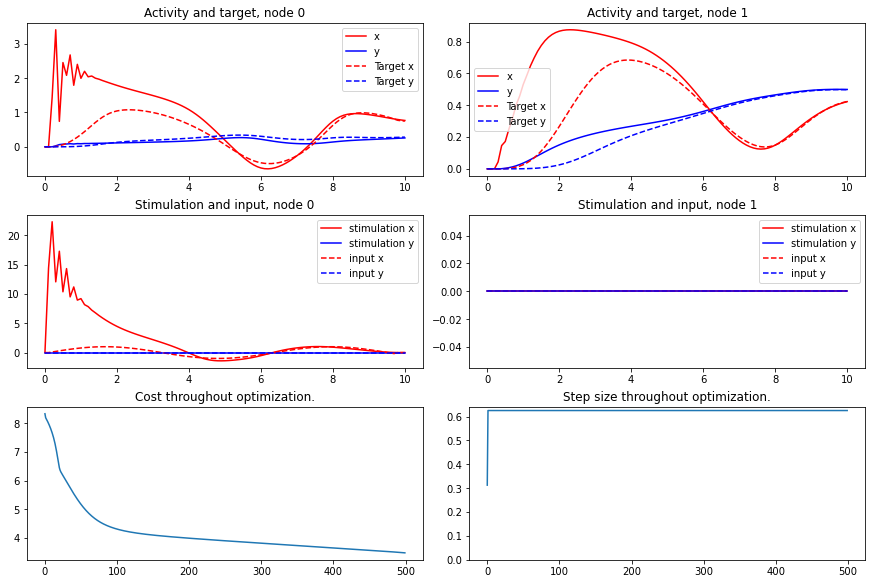

In [12]:
prec_mat = np.zeros( (hopf.params.N, len(hopf.output_vars)) )
prec_mat[1,0] = 1. # only measure in y-channel in node 1

hopf.params["x_ext"] = zero_input_nw[:,0,:]
hopf.params["y_ext"] = zero_input_nw[:,0,:]
hopf_controlled = oc_hopf.OcHopf(hopf, target, w_p=1, w_2=0, print_array=[1,2,10,50,100,200,300,400,500], control_matrix=control_mat, precision_matrix=prec_mat)

hopf_controlled.optimize(500)

state = hopf_controlled.get_xs()
control = hopf_controlled.control

plot_nw(state, target, control, input_nw, hopf_controlled.cost_history, hopf_controlled.step_sizes_history)